In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%cd ..

/home/naomichi/repos/src/github.com/agatan/ocr-experiments


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from ocr.preprocessing.generator import CSVGenerator
from ocr.models import resnet50, bboxnet, mobilenet
from ocr.data import process

In [36]:
tf.keras.backend.set_session(tf.InteractiveSession())
backbone, features_pixel = mobilenet.backbone(input_shape=(512, 832, 3))
training_model, prediction_model = bboxnet.create_model(backbone, features_pixel, input_shape=(512, 832, 3), n_vocab=process.vocab())
tf.keras.backend.get_session().run(tf.global_variables_initializer())
training_model.load_weights('./checkpoint-weights.h5')
# prediction_model.get_weights()

/home/naomichi/repos/src/github.com/agatan/ocr-experiments/venv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [37]:
# gen = CSVGenerator('./data/processed/validation/annotations.csv', features_pixel=features_pixel, input_size=(512, 832), aug=True)
gen = CSVGenerator('./data/processed/hiragana-validation/annotations.csv', features_pixel=features_pixel, input_size=(512, 832))

In [38]:
x, y = next(gen.batches(batch_size=4))
images = x[0]
boxes, text = prediction_model.predict(images)

え
え
え
え
え
え
え


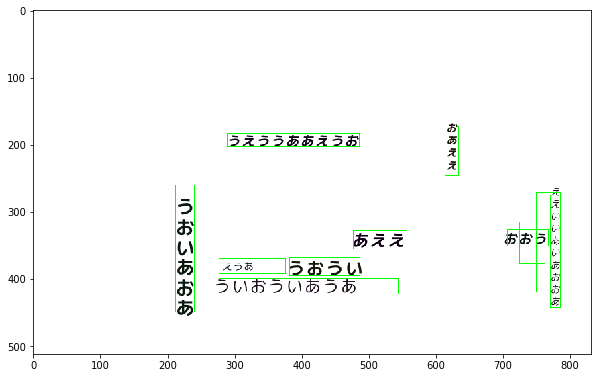

え
え
え
え
え
え
え


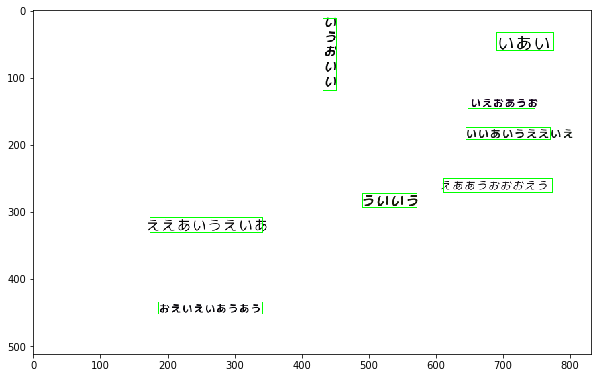

え
え
え


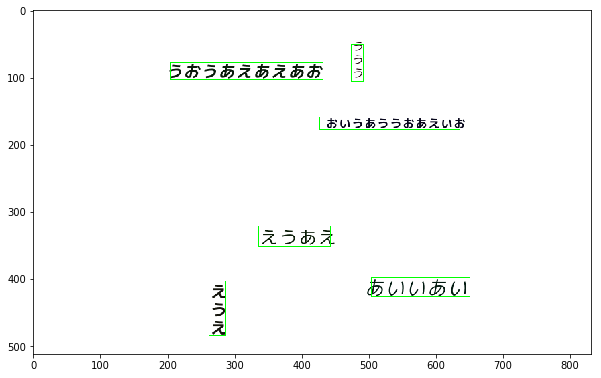

え
え
え


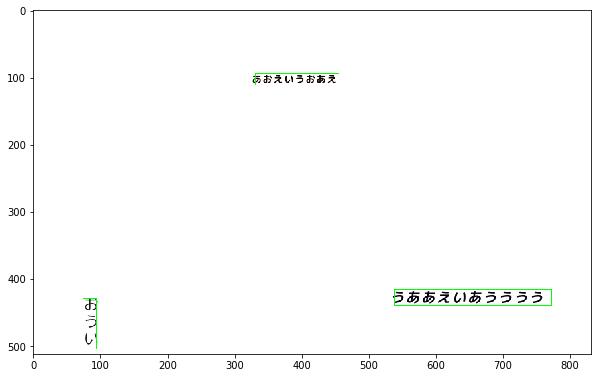

In [39]:
import random
import cv2
import math
import numpy as np
from itertools import groupby

images = x[0]

for i in range(len(images)):
    i_boxes = boxes[i]
    i_text = text[i]
    for ts in i_text:
        decoded = []
        for t in ts:
            if t == -1:
                break
            decoded.append(process.idx2char(t))
        if decoded:
            print(''.join(decoded))
    target = (images[i].copy() * 255).astype(np.int32)

    for (l, t, r, b) in i_boxes:
        cv2.rectangle(target, (l, t), (r, b), (0, 255, 0))

    plt.figure(figsize=(10, 10))
    plt.imshow(target)
    plt.show()

In [40]:
import time
start = time.time()
boxes, text = prediction_model.predict(images[0:1])
print(boxes.shape, text.shape)
print(time.time() - start)

(1, 32, 4) (1, 32, 93)
0.6240663528442383


In [ ]:
boxes

In [ ]:
scores